In [1]:
from lavis.models import model_zoo

print(model_zoo)

c:\Users\ericz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Architectures                  Types
blip_pretrain                  base
blip2_Japanese_feature_extractor pretrain, finetune
blip2_Japanese                 pretrain, finetune


#### Load Model

To change to your customized weights, change pretrained attribute in BLIP2-Japanese\lavis\configs\models\blip2\blip2_pretrain.yaml

In [2]:
from lavis.models import load_model_and_preprocess

model, visual_encoder, text_encoder = load_model_and_preprocess('blip2_Japanese', 'finetune') #load_model_and_preprocess('blip2_Japanese', 'pretrain')

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class SampleDataset(Dataset):

    def __init__(self, img_root, visual_processor) -> None:
        super().__init__()
        self.img_root = img_root
        self.imgs = os.listdir(img_root)
        self.visual_processor = visual_processor

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image_name = self.imgs[index]
        image_path = os.path.join(self.img_root, image_name)
        raw_image = Image.open(image_path).convert("RGB")
        image = self.visual_processor(raw_image)

        return { "image" : image.unsqueeze(0), "name": image_name, "raw": raw_image}

#### Caption Generation Example

In [4]:
caption_generation_dataset = SampleDataset('./samples/caption_generation/', visual_encoder['eval'])

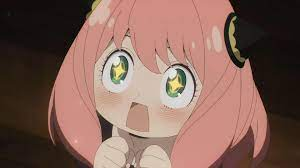

['女の子 が 目 を 見開い て 大きく 口 を 開け て いる']


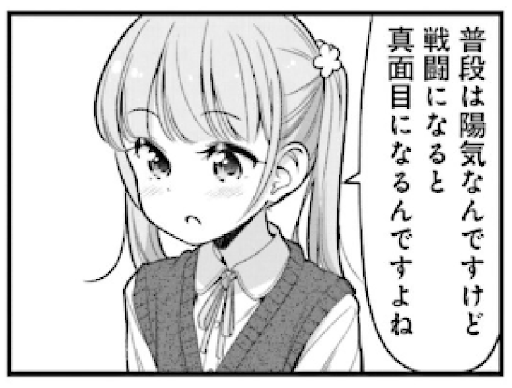

['ネクタイ を 締め た 髪 の 長い 女性 の 絵 が 飾っ て ある']


In [5]:
for item in caption_generation_dataset:
    display(item['raw'])
    print(model.generate(item)) # To use nucleus sampling instead of top k (to generate different captions), set use_nucleus_sampling=True


#### Image Retrieval

In [ ]:
image_retrieval_dataset = SampleDataset('./samples/image_retrieval', visual_encoder['eval'])

In [ ]:
# caption = '男の子がギターを弾いている' # Image 23770160 best matches this caption. 
caption = '結婚式の中で、夫婦の二人が笑っている' # Image 65567.jpg best matches this caption.
# caption = '城の前に男の子が運動している' # Image 81641.jpg best matches this caption.
text_feature = model.extract_features({"text_input": caption}, mode='text')
text_feature.text_embeds.shape

In [ ]:
image_embeds = {}
multimodal = {}
for item in image_retrieval_dataset:
    image_embeds[item['name']] =  model.extract_features(item, mode='image')['image_embeds']
    item['text_input'] = caption
    multimodal[item['name']] =  model.extract_features(item)['multimodal_embeds']

In [ ]:
image_embeds['134206.jpg'].shape

In [ ]:
multimodal['134206.jpg'].shape

In [ ]:
import torch
from torch.nn.functional import cosine_similarity

# Normalized cosine distance in range [0, 1] instead of [-1, 1]
def compute_cosine_distance(embed1, embed2):
    cos_sim = cosine_similarity(embed1.squeeze(0), embed2.squeeze(0), dim=1)
    return torch.mean((cos_sim + 1) / 2)

# Example
compute_cosine_distance(image_embeds['134206.jpg'], multimodal['134206.jpg'])

In [ ]:
best_match = None
best_score = -1
for key in image_embeds:
    score = compute_cosine_distance(image_embeds[key], multimodal[key])
    print(f"key: {key}, cosine similarity between image and multimodal embeddings: {score}")
    if score > best_score:
        best_match = key
        best_score = score
print(f"The best match for the sample caption is {best_match}")